# Aerosols Advanced (BETA): Overlapping Aerosol Species + 2 Aerosol Species Patchy Clouds 

As of POSEIDON V1.3.1. we have included support in emission geometries (direct emission, reflection, thermal scattering) two new beta features: 

1. Overlapping clouds 
- When POSEIDON V1.2.0 was released, emission and reflection geometries could only handle one aerosol species.
- With POSEIDON V1.3.1 it now can handle as many aerosol species as needed, computing the weighted scattering properties for each pressure layer in the atmosphere (including those in regions where more than one aerosol is present).
- Models with multiple clouds can be useful for atmospheres where multiple different aerosol layers are expected to form and overlap (i.e. brown dwarfs which have Fe, Mg2Sio4, and MgSiO3 layers)
- Average w and g are generated in emission_Toon and reflection_Toon (in emission.py) via: 


$\bar{\omega} = \frac{\Delta\tau_{Ray}}{\Delta\tau_{tot}} \; + \frac{\sum_{i}\Delta\tau_{Mie}^i \; \omega_{Mie}^i}{\Delta\tau_{tot}}$

$
\bar{g} = \frac{\sum_i\omega_{Mie}^i \; \Delta\tau_{Mie}^i \; g_{Mie}^i}{\Delta\tau_{Ray} + \sum_i\omega_{Mie}^i \; \Delta\tau_{Mie}^i} 
$

2. Patchy 2D clouds
- POSEIDON V1.2.0 included 1D + 1D patchy Mie clouds. This involved computing two spectra (one clear and one cloudy) and then taking the weighted sum of the two spectra. 
- POSEIDON V1.3.1 now has support for patchy Mie clouds up to two aerosol species. This will compute a 1D + 1D + 1D + 1D weighted spectra where the models are Both Clouds + Cloud 1 + Cloud 2 + Clear.
- This can be useful for brown dwarfs which can have clear sectors, Fe deck sectors, and Fe + MgSiO3 sectors. 

Below, we will show off the above features with HD 189733b emission (with thermal scattering) and reflection, including both SiO2 and MgSiO3 clouds overlapping. 

In [1]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, load_data, define_model, \
                          wl_grid_constant_R, set_priors, read_opacities
from POSEIDON.visuals import plot_data, plot_spectra_retrieved, plot_PT_retrieved
from POSEIDON.retrieval import run_retrieval
from POSEIDON.utility import read_retrieved_spectrum, read_retrieved_PT, \
                             read_retrieved_log_X, plot_collection
from POSEIDON.corner import generate_cornerplot

import numpy as np
from scipy.constants import au
from scipy.constants import parsec as pc

#***** Model wavelength grid *****#

wl_min = 0.2     # Minimum wavelength (um)
wl_max = 13     # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

# We need to provide a model wavelength grid to initialise instrument properties
wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7638*pc
a_p = 0.03142*au

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p)


#***** Define stellar properties *****#

R_s = 0.78*R_Sun      # Stellar radius (m)
T_s = 5014         # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

#***** Define models *****#

model_name_MgSiO3_SiO2_overlapping = 'HD189-Emission-and-Reflection-MgSiO3-SiO2-Overlapping'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2', 'H2O', 'K','Na',]
aerosol_species = ['MgSiO3','SiO2']

# Create the model object
model_MgSiO3_SiO2_overlapping = define_model(model_name_MgSiO3_SiO2_overlapping, bulk_species, param_species, 
                                            PT_profile = 'Guillot_dayside',             # Parametric PT profile for emission
                                            cloud_model = 'Mie',cloud_type = 'slab',    # Slab model for both aerosol species
                                            aerosol_species = aerosol_species,          # Including both MgSiO3 and SiO2
                                            scattering = True,                          # Turn on thermal scattering
                                            reflection = True,                          # Turn on reflection
                                            cloud_dim = 1)                              


model_name_MgSiO3_SiO2_overlapping_patchy = 'HD189-Emission-and-Reflection-MgSiO3-SiO2-Overlapping-Patchy'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2', 'H2O', 'K','Na',]
aerosol_species = ['MgSiO3','SiO2']

# Create the model object
model_MgSiO3_SiO2_overlapping_patchy = define_model(model_name_MgSiO3_SiO2_overlapping_patchy, bulk_species, param_species, 
                                            PT_profile = 'Guillot_dayside',             # Parametric PT profile for emission
                                            cloud_model = 'Mie',cloud_type = 'slab',    # Slab model for both aerosol species
                                            aerosol_species = aerosol_species,          # Including both MgSiO3 and SiO2
                                            scattering = True,                          # Turn on thermal scattering
                                            reflection = True,                          # Turn on reflection
                                            cloud_dim = 2)                              # <--- Cloud Dimension is 2 (Patchy)

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


Lets look at the cloud params for both models defined above

In [2]:
print(model_MgSiO3_SiO2_overlapping['cloud_param_names'])

['log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3' 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2'
 'log_X_SiO2']


Note that the patchy model has the aerosol parameters, and then weights for

f_both = Both aerosols present in forward model 

f_aerosol_1 = Only MgSiO3

f_aerosol_2 = Only SiO2

f_clear = No aerosols in forward model 

These are defined from 0 to 1, and in both forward models and retrievals, these are ensured to add to one

In [3]:
print(model_MgSiO3_SiO2_overlapping_patchy['cloud_param_names'])

['f_both' 'f_aerosol_1' 'f_aerosol_2' 'f_clear' 'log_P_top_slab_MgSiO3'
 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3' 'log_X_MgSiO3'
 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2']


Load in the cross sections.

In [4]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100    # Same as prior range for T
T_fine_max = 3000    # Same as prior range for T
T_fine_step = 20     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

#***** Run atmospheric retrieval *****#
opac = read_opacities(model_MgSiO3_SiO2_overlapping, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO done
CO2 done
H2O done
K done
Na done
Opacity pre-interpolation complete.


We define the aerosol slabs to intersect:

In [5]:
R_p_ref             =   1.121 * R_J

# PT Params
log_kappa_IR        =   -4.32 
log_gamma           =   -0.59
T_int               =   158.1
T_equ               =   1092.6

# Gas mixing ratios
log_CO              =   -4.85 
log_CO2             =   -6.60 
log_H2O             =   -4.74 
log_K               =   -7.90 
log_Na              =   -5.12 

# SiO2 aerosol properties
log_P_top_slab_SiO2 =   -3
Delta_log_P_SiO2    =   5
log_r_m_SiO2        =   -2 
log_X_SiO2          =   -13

# MgSio3 aerosol properties
log_P_top_slab_MgSiO3 =   -3
Delta_log_P_MgSiO3    =   2
log_r_m_MgSiO3        =   -1.5
log_X_MgSiO3          =   -14

Overlapping Clouds (non-patchy) atmosphere object generation

In [6]:
from POSEIDON.core import make_atmosphere

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])

log_X_params = np.array([log_CO,log_CO2, log_H2O, log_K, log_Na])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3,
                         log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2])

atmosphere_MgSiO3_SiO2_overlapping = make_atmosphere(planet, model_MgSiO3_SiO2_overlapping, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

Overlapping Clouds (patchy) atmosphere object generation

We will do 
1. 100% Clear 
2. 100% MgSiO3 
3. 100% SiO2 
4. 100% Both 
5. 25% Clear + 25% MgSiO3 + 25% SiO2 + 25% Both

In [7]:
from POSEIDON.core import make_atmosphere

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])

log_X_params = np.array([log_CO,log_CO2, log_H2O, log_K, log_Na])

f_both = 0
f_aerosol_1 = 0 
f_aerosol_2 = 0 
f_clear = 1 # 100% Clear

cloud_params = np.array([f_both, f_aerosol_1, f_aerosol_2, f_clear, 
                         log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3,
                         log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2])

atmosphere_clear = make_atmosphere(planet, model_MgSiO3_SiO2_overlapping_patchy, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

f_both = 0
f_aerosol_1 = 1 # 100% MgSiO3
f_aerosol_2 = 0 
f_clear = 0

cloud_params = np.array([f_both, f_aerosol_1, f_aerosol_2, f_clear, 
                         log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3,
                         log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2])

atmosphere_MgSiO3 = make_atmosphere(planet, model_MgSiO3_SiO2_overlapping_patchy, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

f_both = 0
f_aerosol_1 = 0
f_aerosol_2 = 1 # 100% SiO2 
f_clear = 0

cloud_params = np.array([f_both, f_aerosol_1, f_aerosol_2, f_clear, 
                         log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3,
                         log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2])

atmosphere_SiO2 = make_atmosphere(planet, model_MgSiO3_SiO2_overlapping_patchy, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

f_both = 1 # 100% Both
f_aerosol_1 = 0
f_aerosol_2 = 0
f_clear = 0

cloud_params = np.array([f_both, f_aerosol_1, f_aerosol_2, f_clear, 
                         log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3,
                         log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2])

atmosphere_both = make_atmosphere(planet, model_MgSiO3_SiO2_overlapping_patchy, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

f_both = 0.25      # 25% Both
f_aerosol_1 = 0.25 # 25% MgSiO3
f_aerosol_2 = 0.25 # 25% SiO2
f_clear = 0.25     # 25% Clear

cloud_params = np.array([f_both, f_aerosol_1, f_aerosol_2, f_clear, 
                         log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3,
                         log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2])

atmosphere_patchy = make_atmosphere(planet, model_MgSiO3_SiO2_overlapping_patchy, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

Lets look at the pressure-temperature profile, and aerosol vertical extent 

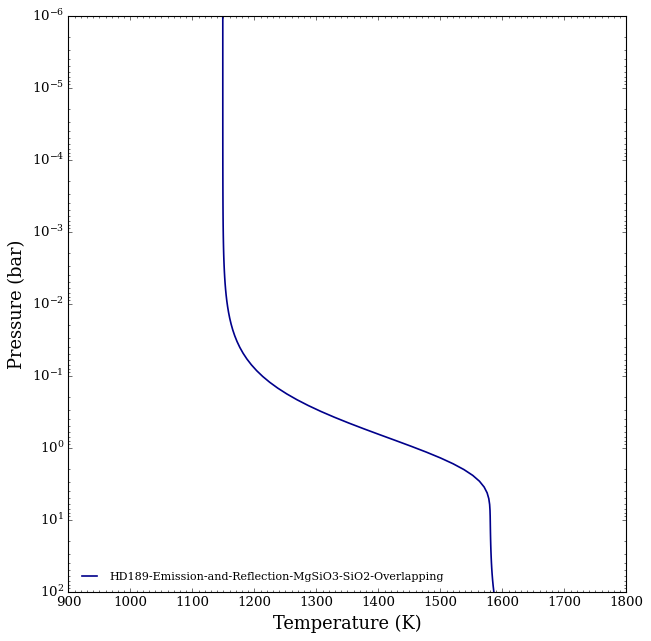

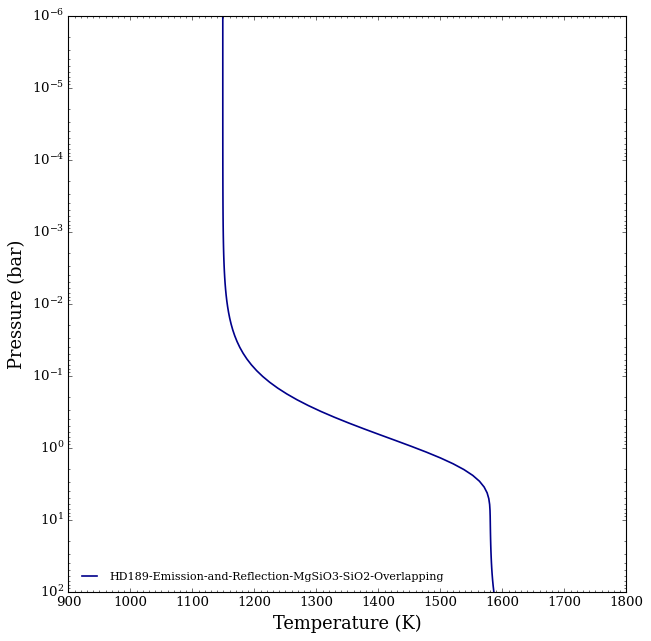

In [8]:
from POSEIDON.visuals import plot_PT

plot_PT(planet, model_MgSiO3_SiO2_overlapping, atmosphere_clear)

As we can see, MgSio3 and SiO2 overlap from 1e-1 to 1e-3 bars

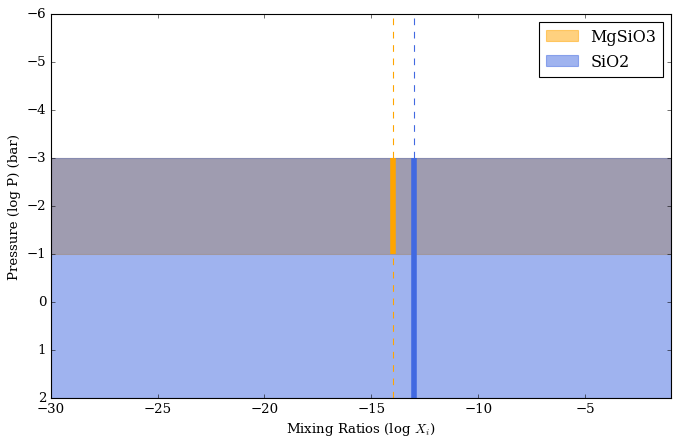

In [9]:
from POSEIDON.clouds import plot_clouds, find_nearest
import matplotlib.pyplot as plt

plot_clouds(planet, model_MgSiO3_SiO2_overlapping, atmosphere_MgSiO3_SiO2_overlapping)

Now lets compute some spectra! 

1D Overlapping Spectra:

In [10]:
from POSEIDON.core import compute_spectrum

Fp_Fs_overlapping = compute_spectrum(planet, star, model_MgSiO3_SiO2_overlapping, atmosphere_MgSiO3_SiO2_overlapping, opac, wl, 
                                       spectrum_type = 'emission', return_albedo = False) 


Patchy Spectra:

In [11]:
Fp_Fs_clear  = compute_spectrum(planet, star, model_MgSiO3_SiO2_overlapping_patchy, atmosphere_clear, opac, wl, 
                                spectrum_type = 'emission', return_albedo = False) 


In [12]:
Fp_Fs_MgSiO3  = compute_spectrum(planet, star, model_MgSiO3_SiO2_overlapping_patchy, atmosphere_MgSiO3, opac, wl, 
                                spectrum_type = 'emission', return_albedo = False) 


In [13]:
Fp_Fs_SiO2  = compute_spectrum(planet, star, model_MgSiO3_SiO2_overlapping_patchy, atmosphere_SiO2, opac, wl, 
                                spectrum_type = 'emission', return_albedo = False) 

In [14]:
Fp_Fs_both  = compute_spectrum(planet, star, model_MgSiO3_SiO2_overlapping_patchy, atmosphere_both, opac, wl, 
                                spectrum_type = 'emission', return_albedo = False) 


In [15]:
Fp_Fs_patchy  = compute_spectrum(planet, star, model_MgSiO3_SiO2_overlapping_patchy, atmosphere_patchy, opac, wl, 
                                spectrum_type = 'emission', return_albedo = False) 


Lets first plot the overlapping clouds (1D model)

This should be identical to the patchy model that is 100% the atmosphere with both aerosols

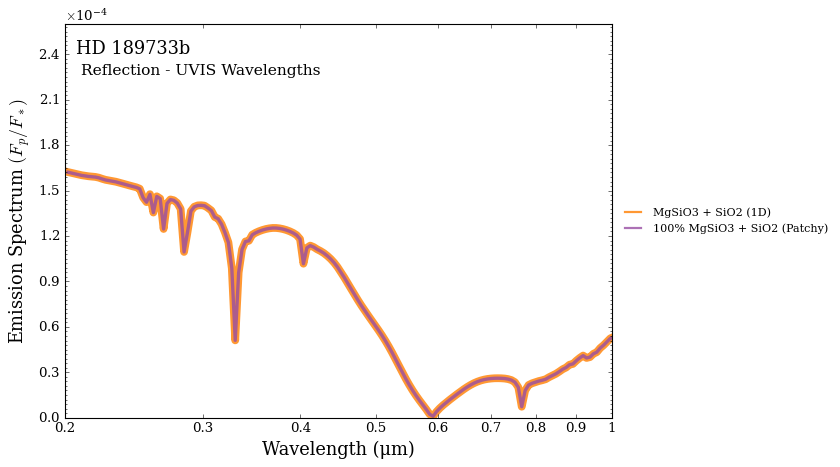

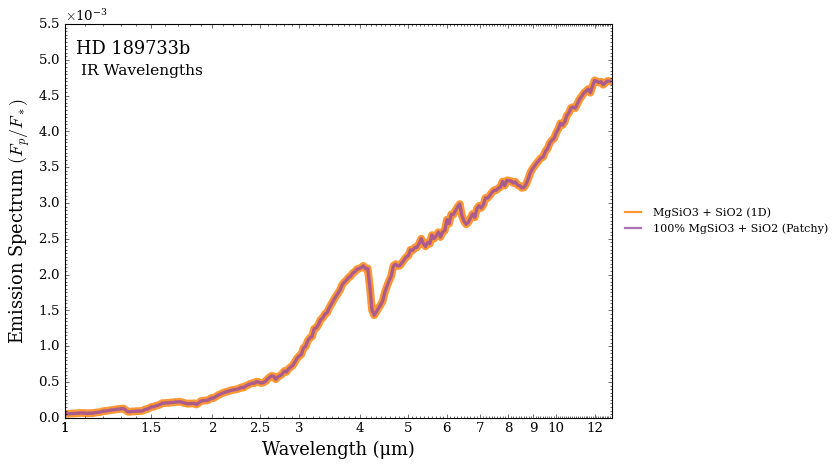

In [16]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectra = []

# Add the three model spectra to the plot collection object
spectra = plot_collection(Fp_Fs_overlapping, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_both, wl, collection = spectra)

# Plot spectra
title = 'Reflection - UVIS Wavelengths'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['MgSiO3 + SiO2 (1D)', '100% MgSiO3 + SiO2 (Patchy)'],
                        legend_location = 'outside right', wl_axis = 'log', colour_list = ['#ff7f00', '#984ea3',],
                        plt_label = title,
                        figure_shape = 'wide', 
                        line_widths = [7,3],
                        wl_max = 1, y_max = 2.6e-4)

# Plot spectra
title = 'IR Wavelengths'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['MgSiO3 + SiO2 (1D)', '100% MgSiO3 + SiO2 (Patchy)'],
                        legend_location = 'outside right', wl_axis = 'log', colour_list = ['#ff7f00', '#984ea3',],
                        plt_label = title,
                        figure_shape = 'wide', 
                        line_widths = [7,3],
                        wl_min = 1)


Lets plot all the patchy models now 

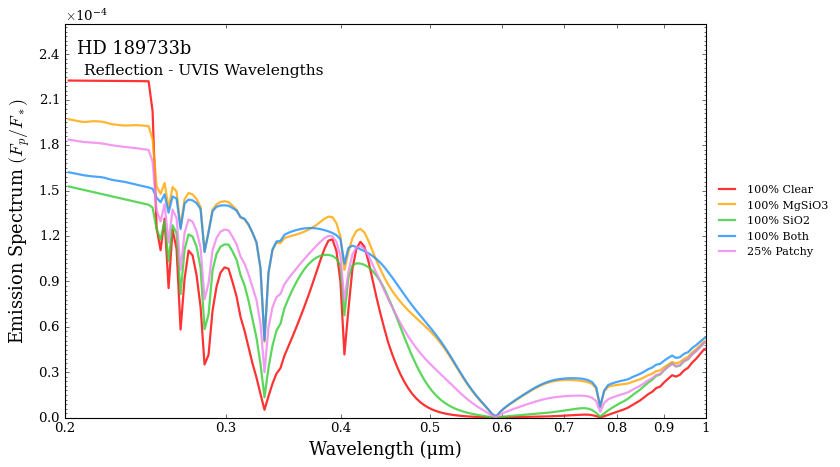

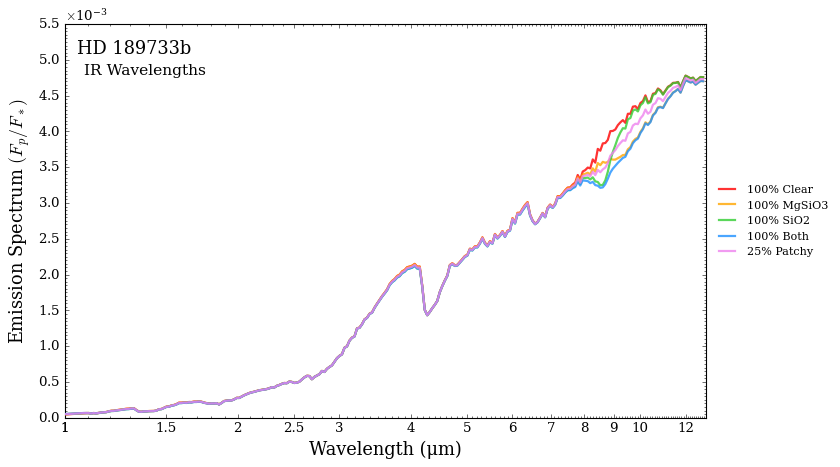

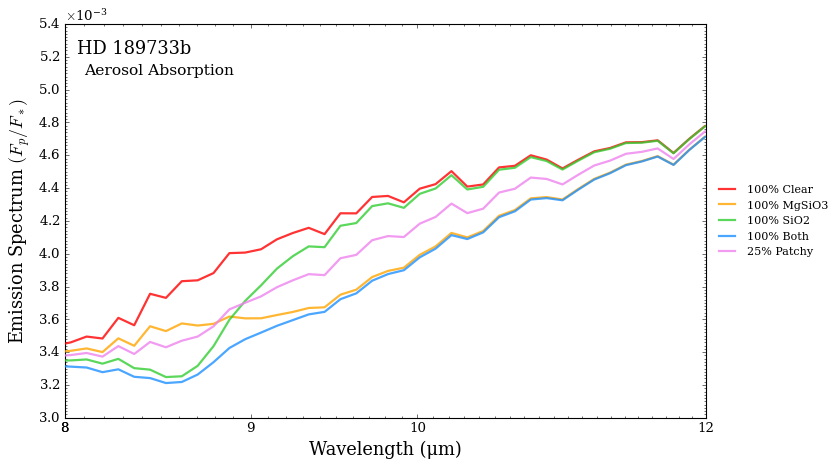

In [17]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectra = []

# Add the three model spectra to the plot collection object
spectra = plot_collection(Fp_Fs_clear, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_MgSiO3, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_SiO2, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_both, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_patchy, wl, collection = spectra)

# Plot spectra
title = 'Reflection - UVIS Wavelengths'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['100% Clear', '100% MgSiO3', '100% SiO2', '100% Both', '25% Patchy'],
                        legend_location = 'outside right', wl_axis = 'log', colour_list = ['red', 'orange','limegreen','dodgerblue','violet'],
                        plt_label = title,
                        figure_shape = 'wide', 
                        wl_max = 1, y_max = 2.6e-4)

# Plot spectra
title = 'IR Wavelengths'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['100% Clear', '100% MgSiO3', '100% SiO2', '100% Both', '25% Patchy'],
                        legend_location = 'outside right', wl_axis = 'log', colour_list = ['red', 'orange','limegreen','dodgerblue','violet'],
                        plt_label = title,
                        figure_shape = 'wide', 
                        wl_min = 1)


# Plot spectra
title = 'Aerosol Absorption'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['100% Clear', '100% MgSiO3', '100% SiO2', '100% Both', '25% Patchy'],
                        legend_location = 'outside right', wl_axis = 'log', colour_list = ['red', 'orange','limegreen','dodgerblue','violet'],
                        plt_label = title,
                        figure_shape = 'wide', 
                        wl_min = 8, wl_max = 12,
                        y_min = 3e-3)
